In [1]:
import keras
keras.__version__

/Users/chrisheinrich/anaconda/envs/deep/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/chrisheinrich/anaconda/envs/deep/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5
  return f(*args, **kwds)


'2.1.5'

In [2]:
import os

home_dir = os.getcwd()
fname = os.path.join(home_dir,'data/train_data.csv')

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
lines = lines[:-1]

print(header)
print(len(lines))

['sentiment', 'text']
5250


### Exploring the dataset


In [3]:
sents = [0,0,0,0,0]
labels = []
texts = []
for line in lines:
    sent = int(line.split(',')[0])
    tweet = line.split(',')[1]
    sents[sent -1] +=1
    texts.append(tweet)
    labels.append(sent-1) #data is labeled 1-5, so we shift by 1 so it starts with 0
    
print(sents)
print(len(labels))
print(len(texts))

print("A sample tweet: " + texts[6] )
print("Has sentiment: " + str(labels[6]))

[76, 473, 3287, 1062, 352]
5250
5250
A sample tweet: Autonomous vehicles could reduce traffic fatalities by 90%...I'm in!
Has sentiment: 4


### Tokenize the data

We first vectorize the data we collected and prepare a training and validation split.

In [4]:
from keras.preprocessing.text import Tokenizer
import numpy as np

maxlen = 20 # We cut the tweet after 20 words (most are shorter than this anyway)
training_samples = 4000
validation_samples = len(labels) - training_samples
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

x_train = sequences[:training_samples]
y_train = labels[:training_samples]

x_val = sequences[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
y_train[0]

Found 10982 unique tokens.


4

### Vectorize the data


In [5]:
import numpy as np

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1  # set specific indices of results[i] to 1s
    return results

# Our vectorized training data
x_train = vectorize_sequences(x_train)
# Our vectorized test data
x_val = vectorize_sequences(x_val)
        

In [6]:
x_train[0]

array([0., 0., 1., ..., 0., 0., 0.])

We one-hot encode the lables using a Keras convenience function

In [7]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train,)
y_val = to_categorical(y_val,)

In [38]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
#model.add(layers.Dropout(0.2))
#model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(5, activation='softmax')) 

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_21 (Dense)             (None, 5)                 85        
Total params: 160,101
Trainable params: 160,101
Non-trainable params: 0
_________________________________________________________________


In [40]:
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [41]:
history = model.fit(x_train,y_train,epochs = 20, batch_size=128,validation_data=(x_val,y_val))

Train on 4000 samples, validate on 1250 samples
Epoch 1/20
4000/4000 [==============================] - 1s 147us/step - loss: 1.3336 - acc: 0.6168 - val_loss: 1.2152 - val_acc: 0.5936
Epoch 2/20
4000/4000 [==============================] - 0s 88us/step - loss: 1.1144 - acc: 0.6362 - val_loss: 1.1489 - val_acc: 0.5936
Epoch 3/20
4000/4000 [==============================] - 0s 87us/step - loss: 1.0357 - acc: 0.6370 - val_loss: 1.1106 - val_acc: 0.5992
Epoch 4/20
4000/4000 [==============================] - 0s 87us/step - loss: 0.9660 - acc: 0.6445 - val_loss: 1.0764 - val_acc: 0.6136
Epoch 5/20
4000/4000 [==============================] - 0s 85us/step - loss: 0.8973 - acc: 0.6637 - val_loss: 1.0563 - val_acc: 0.6272
Epoch 6/20
4000/4000 [==============================] - 0s 85us/step - loss: 0.8343 - acc: 0.6827 - val_loss: 1.0336 - val_acc: 0.6272
Epoch 7/20
4000/4000 [==============================] - 0s 85us/step - loss: 0.7768 - acc: 0.7037 - val_loss: 1.0276 - val_acc: 0.6224
Epoch 

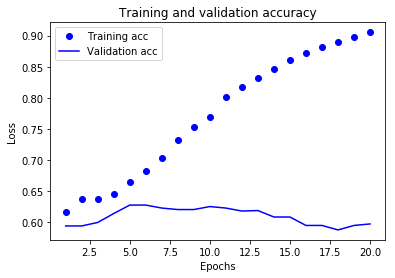

In [42]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

Looks like we start over fitting around 6 epochs, reaching a maximum accuracy of 63%. This is not so good considering this is accuracy you would get if you just guessed a neutral sentiment(3) for every tweet.  


## Casting as a binary classification problem

One of the reasons this classification is challenging is that there are 5 classes, and the majority of the sentiments are neutral (i.e. 3). I am interested to see what the accuracy is like if we instead cast this as a binary classification problem. We will do this by throwing away all of the neutral reviews, setting the negative reviews to 0 and positive reviews to 1

In [45]:
labels = []
texts = []
for line in lines:
    sent = int(line.split(',')[0])
    tweet = line.split(',')[1]
    if sent < 3:
        texts.append(tweet)
        labels.append(0)
    if sent > 3:
        texts.append(tweet)
        labels.append(1)

print(len(labels))
print(len(texts))

print("A sample tweet: " + texts[6] )
print("Has sentiment: " + str(labels[6]))

1963
1963
A sample tweet: The future! So buying one of these. ̢���@CNET: Audi is ready to test autonomous cars on public roads http://t.co/aZTbHLcy #CES #2013CES̢����
Has sentiment: 1


In [53]:
from keras.preprocessing.text import Tokenizer
import numpy as np

maxlen = 20 # We cut the tweet after 20 words (most are shorter than this anyway)
training_samples = 1400
validation_samples = len(labels) - training_samples
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

x_train = sequences[:training_samples]
y_train = labels[:training_samples]

x_val = sequences[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]
y_train[0]

def vectorize_sequences(sequences, dimension=10000):
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1  # set specific indices of results[i] to 1s
    return results


# Our vectorized training data
x_train = vectorize_sequences(x_train)
# Our vectorized test data
x_val = vectorize_sequences(x_val)
        

Found 5192 unique tokens.


In [55]:
# Our vectorized labels
y_train = np.asarray(y_train).astype('float32')
y_test = np.asarray(y_val).astype('float32')

In [56]:
y_train[0]

1.0

In [57]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
#model.add(layers.Dropout(0.2))
#model.add(layers.Dense(32, activation='relu'))
#model.add(layers.Dropout(0.2))
model.add(layers.Dense(1, activation='sigmoid')) 

In [58]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

In [60]:
history = model.fit(x_train,y_train,epochs = 20, batch_size=128,validation_data=(x_val,y_val))

Train on 1400 samples, validate on 563 samples
Epoch 1/20
1400/1400 [==============================] - 1s 366us/step - loss: 0.6695 - acc: 0.6557 - val_loss: 0.6387 - val_acc: 0.7531
Epoch 2/20
1400/1400 [==============================] - 0s 120us/step - loss: 0.6235 - acc: 0.7114 - val_loss: 0.6118 - val_acc: 0.7513
Epoch 3/20
1400/1400 [==============================] - 0s 114us/step - loss: 0.5894 - acc: 0.7121 - val_loss: 0.5921 - val_acc: 0.7513
Epoch 4/20
1400/1400 [==============================] - 0s 125us/step - loss: 0.5578 - acc: 0.7243 - val_loss: 0.5777 - val_acc: 0.7513
Epoch 5/20
1400/1400 [==============================] - 0s 119us/step - loss: 0.5271 - acc: 0.7486 - val_loss: 0.5663 - val_acc: 0.7531
Epoch 6/20
1400/1400 [==============================] - 0s 115us/step - loss: 0.4969 - acc: 0.7807 - val_loss: 0.5575 - val_acc: 0.7531
Epoch 7/20
1400/1400 [==============================] - 0s 115us/step - loss: 0.4670 - acc: 0.8014 - val_loss: 0.5522 - val_acc: 0.7584
E

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

acc = history.history['acc']
val_acc = history.history['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

This gets us to a max accuracy of around 76%. However, considering this dataset isn't balanced (about 72% are positive and 28% negative), we are actually only doing slightly better than if we had just guesed positive for all of the reviews. One plausible explanation here is that their just isn't much training data. 